In [19]:
import sys
sys.path.append('..')
import matplotlib.pyplot as plt

In [10]:
#from DA_PoC.dynamical_systems.sw_numerical_model 
from DA_PoC.dynamical_systems.examples.sw import SWModelJax
from DA_PoC.common.numerical_model import NumericalModel

from DA_PoC.common.observation_operator import LinearObservationOperator
import numpy as np

In [4]:
n_x = 32
dx = 5e3
n_y = 32
dy = 5e3
swmodel = SWModelJax(n_x, dx, n_y, dy, periodic_x=True)


In [110]:
state_dimension = 3 * swmodel.state_variable_length
obs_dimension = swmodel.state_variable_length
h_no_nan = np.eye(swmodel.state_variable_length)
for i in range(swmodel.state_variable_length):
    if i % 32 == 0:
        h_no_nan[i, i] = 0
        h_no_nan[i-1, i-1] = 0

H_obs = np.hstack(
    [
        np.zeros((swmodel.state_variable_length, swmodel.state_variable_length)),
        np.zeros((swmodel.state_variable_length, swmodel.state_variable_length)),
        h_no_nan,
    ]
)
obs_operator = LinearObservationOperator(Hmatrix=H_obs)
window = 15
# print(f"{lorenz.obs.shape=}")
# print(f"{lorenz.H=}")
numerical_model_sw = NumericalModel(state_dimension, obs_dimension)
background = np.zeros(state_dimension)
background[swmodel.slice_h] = swmodel.depth
numerical_model_sw.background = background
numerical_model_sw.background_error_cov_inv = np.eye(state_dimension)
numerical_model_sw.set_observation_operator(obs_operator)
def remove_nan(array):
    array[np.isnan(array)] = 0
    return array
numerical_model_sw.set_forward(lambda x: swmodel.forward(x, n_steps=window))
numerical_model_sw.set_tangent_linear(
    lambda x: swmodel.forward_TLM_h(x, n_steps=window)
)
x0_t = background
x0_t[swmodel.slice_h] += 3 * np.random.randn(swmodel.state_variable_length)

Observation operator set already


In [111]:
# new_state = numerical_model_sw.forward_no_obs(x0_t)
def generate_obs_no_noise(x0, n_steps):
    return remove_nan(swmodel.forward(x0, n_steps=n_steps)[swmodel.slice_h])
true_obs = generate_obs_no_noise(x0_t, 500)


501it [01:04,  7.80it/s]                         


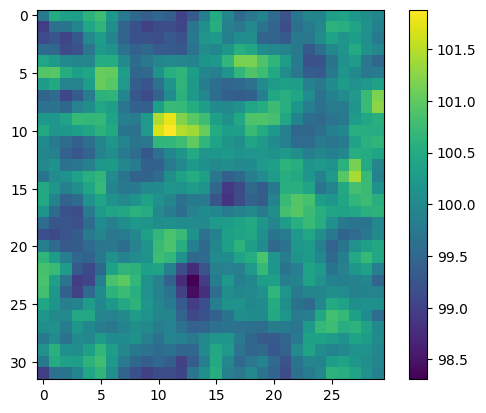

In [112]:
plt.imshow(true_obs.reshape(32, 30))
plt.colorbar()

(960,)

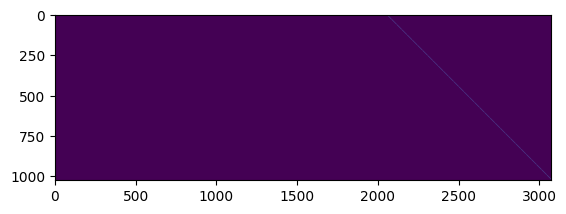

In [113]:
noisy_obs = true_obs +  np.random.normal(loc=0, scale=0.1, size=true_obs.shape)

In [114]:
numerical_model_sw.set_obs(noisy_obs)

# numerical_model_sw.cost_function(x0_t)


16it [00:02,  7.22it/s]                        


TypeError: sub got incompatible shapes for broadcasting: (1024,), (960,).

In [120]:
no_obs = numerical_model_sw.forward_no_obs(x0_t)

16it [00:02,  7.32it/s]                        


In [144]:
#print(remove_nan(no_obs[swmodel.slice_h]).shape)
np.isnan(H_obs @ no_obs).sum()

(3072,)

16it [00:02,  7.31it/s]                        
16it [00:02,  7.44it/s]                        
16it [00:02,  7.39it/s]                        
16it [00:02,  7.40it/s]                        
16it [00:02,  7.39it/s]                        
16it [00:02,  7.44it/s]                        
16it [00:02,  7.39it/s]                        
16it [00:02,  7.23it/s]                        
16it [00:02,  7.29it/s]                        
16it [00:02,  7.38it/s]                        
16it [00:02,  7.35it/s]                        
16it [00:02,  7.35it/s]                        
16it [00:02,  6.37it/s]                        
16it [00:02,  7.37it/s]                        
16it [00:02,  7.44it/s]                        
16it [00:02,  7.36it/s]                        
16it [00:02,  7.26it/s]                        
16it [00:02,  7.20it/s]                        
16it [00:02,  7.38it/s]                        
16it [00:02,  7.36it/s]                        
16it [00:02,  7.29it/s]                 

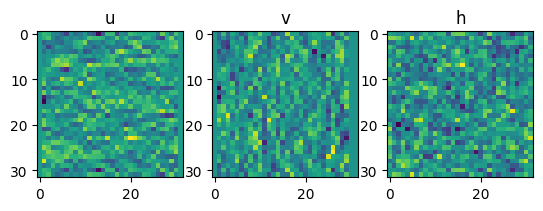

<Figure size 640x480 with 0 Axes>

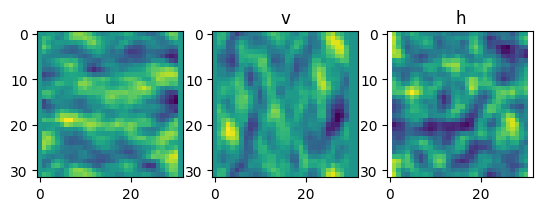

In [33]:
swmodel.plot_state_imshow(x0_t)
swmodel.plot_state_imshow(new_state)
plt.figure()
for _ in range(50):
    new_state = numerical_model_sw.forward_no_obs(new_state)

plt.figure()
swmodel.plot_state_imshow(new_state)